# This notebook is for visualizations of our models 


# Importing neccessary libraries and functions

In [212]:
import tensorflow as tf
import scipy
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential

import glob
from keras import models
#from ann_visualizer.visualize import ann_viz;
import pickle as pkl
import numpy as np
import pandas as pd #more libraries and modules
import matplotlib.pyplot as plt
import six
np.random.seed(123)
# from tf_cnnvis import deepdream_visualization
import splitfolders
import seaborn as sns
from keract import get_activations, display_activations,display_heatmaps,get_gradients_of_activations
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn import metrics
import itertools

plt.style.use('seaborn')


In [213]:
import numpy as np
import pandas as pd #more libraries and modules
import matplotlib.pyplot as plt
import six
from sklearn import metrics
np.random.seed(123) #very important for reproducibility

In [214]:
def plotLearningCurve(history,epochs): #function to show model learning 
    epochRange = range(1,epochs+1)
    plt.plot(epochRange,history.history['accuracy'])
    plt.plot(epochRange,history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

    plt.plot(epochRange,history.history['loss'])
    plt.plot(epochRange,history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

In [215]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap='OrRd_r'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#function to make confusion matrix look nice

In [216]:
def deprocess(img):
    return tf.cast(img, tf.float32)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(tf.cast(img, tf.uint8))))
# Create the feature extraction model
    
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),))
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
                gradients = tape.gradient(loss, img)

        # Normalize the gradients.
                gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
                img = img + gradients*step_size
#                 img = tf.clip_by_value(img, -1, 1)

        return loss, img
def run_deep_dream_simple(img, steps=100, step_size=0.01):
      # Convert from uint8 to the range expected by the model.
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps
    
        loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
        display.clear_output(wait=True)
        show(img)
        print ("Step {}, loss {}".format(step, loss))


        result = img
        display.clear_output(wait=True)
        show(result)

    return result

In [217]:
def generatedeepdreamimg(imagebatch,model,imageposinbatch):
    base_model = model

    names = [name.name for name in  base_model.layers]
    layers = [base_model.get_layer(name).output for name in names[:]]

# Create the feature extraction model
    dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

    original_img = np.array(imagebatch)
    original_img = original_img[imageposinbatch]
    original_img = ((original_img)).astype(np.float32)
    dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

# show(deprocess(original_img))
    deepdream = DeepDream(dream_model)
    dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=1000, step_size=0.5)
    return dream_img




In [218]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns,**kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax
#saving classification report for presentation 


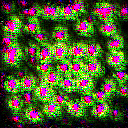

In [219]:
base_model = model

names = [name.name for name in  base_model.layers]
layers = [base_model.get_layer(name).output for name in names[:]]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
pickedpic= testDatagen[0][0]
img = generatedeepdreamimg(pickedpic,model,1)
deepdreamimages=[]
pickedpic= testDatagen
num = 0
for i,v in loclist:
    print(i,v)
    pickedpic = testDatagen[i][0]
    img = generatedeepdreamimg(pickedpic,model,v)
    deepdreamimages.append(img)


In [266]:
final_model = Sequential()
#setting up final model structure for import
final_model.add(Conv2D(16,(3,3),activation='relu',padding='same',input_shape=(128,128,3)))
final_model.add(MaxPool2D(2,2, padding='same'))
final_model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
final_model.add(MaxPool2D(2,2, padding='same'))
final_model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
final_model.add(MaxPool2D(2,2, padding='same'))
final_model.add(Flatten())
final_model.add(Dense(128,activation='relu'))
final_model.add(Dropout(0.2))
final_model.add(Dense(64,activation='relu'))
final_model.add(Dropout(0.2))
final_model.add(Dense(64,activation='relu'))
final_model.add(Dropout(0.2))

final_model.add(Dense(1,activation='sigmoid'))

In [269]:
final_model.load_weights('weights.hd5')

In [270]:
final_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [271]:
final_model.evaluate(testDatagen)

22/22 [==============================] - 1s 30ms/step - loss: 0.1576 - accuracy: 0.9516


[0.1575832962989807, 0.9515669345855713]

In [296]:
test_preds=model.predict_classes(testDatagen)
#generating model's predicted classes for test set

## Adressing Misclasiffications

In [277]:
ans = []
for v in range(len(testDatagen)):
    pickedbatch = testDatagen[v][0]
    batch_classes=testDatagen[v][1]
    prediction = model.predict_classes(pickedbatch)
    for i,v in list(zip(batch_classes,prediction)):
        ans.append((('orig:',i),('prediction:',v)))

In [278]:
count=0
new_list=[]
loclist = []
for i,v in ans:
    if i[1]!=v[1]:
        print('orig:',i[1],'predicted:',float(v[1]),'batch:',(count//16),'index:',(count % 16))
        loclist.append((count//16,count % 16))
        if i[1]==1 and v[1]==0:
            new_list.append((testDatagen[count//16][0][count % 16],
                             f'False Positive! \n orig:{i[1]} predicted {float(v[1])}'))
        else:
            new_list.append((testDatagen[count//16][0][count % 16],
                             f'False Negative! \n orig:{i[1]} predicted {float(v[1])}'))
    count+=1

orig: 1.0 predicted: 0.0 batch: 3 index: 6
orig: 0.0 predicted: 1.0 batch: 3 index: 11
orig: 1.0 predicted: 0.0 batch: 4 index: 4
orig: 1.0 predicted: 0.0 batch: 5 index: 6
orig: 0.0 predicted: 1.0 batch: 5 index: 14
orig: 0.0 predicted: 1.0 batch: 5 index: 15
orig: 1.0 predicted: 0.0 batch: 6 index: 6
orig: 0.0 predicted: 1.0 batch: 7 index: 2
orig: 0.0 predicted: 1.0 batch: 8 index: 3
orig: 1.0 predicted: 0.0 batch: 9 index: 9
orig: 1.0 predicted: 0.0 batch: 10 index: 0
orig: 1.0 predicted: 0.0 batch: 10 index: 10
orig: 1.0 predicted: 0.0 batch: 10 index: 13
orig: 0.0 predicted: 1.0 batch: 12 index: 6
orig: 0.0 predicted: 1.0 batch: 12 index: 14
orig: 1.0 predicted: 0.0 batch: 14 index: 6
orig: 0.0 predicted: 1.0 batch: 14 index: 10
orig: 1.0 predicted: 0.0 batch: 20 index: 5
orig: 0.0 predicted: 1.0 batch: 20 index: 13


In [279]:
loclist

[(3, 6),
 (3, 11),
 (4, 4),
 (5, 6),
 (5, 14),
 (5, 15),
 (6, 6),
 (7, 2),
 (8, 3),
 (9, 9),
 (10, 0),
 (10, 10),
 (10, 13),
 (12, 6),
 (12, 14),
 (14, 6),
 (14, 10),
 (20, 5),
 (20, 13)]

run this to get pics of specific filters

In [280]:
# activations = get_activations(model, testDatagen[0][0][5:6],output_format='simple')
# # display_activations(activations)
# display_heatmaps(activations,testDatagen[0][0][5:6],)

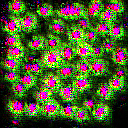

In [281]:
deepdreamimages=[]
pickedpic= testDatagen
num = 0
for i,v in loclist:
    print(i,v)
    pickedpic = testDatagen[i][0]
    img = generatedeepdreamimg(pickedpic,model,v)
    deepdreamimages.append(img)


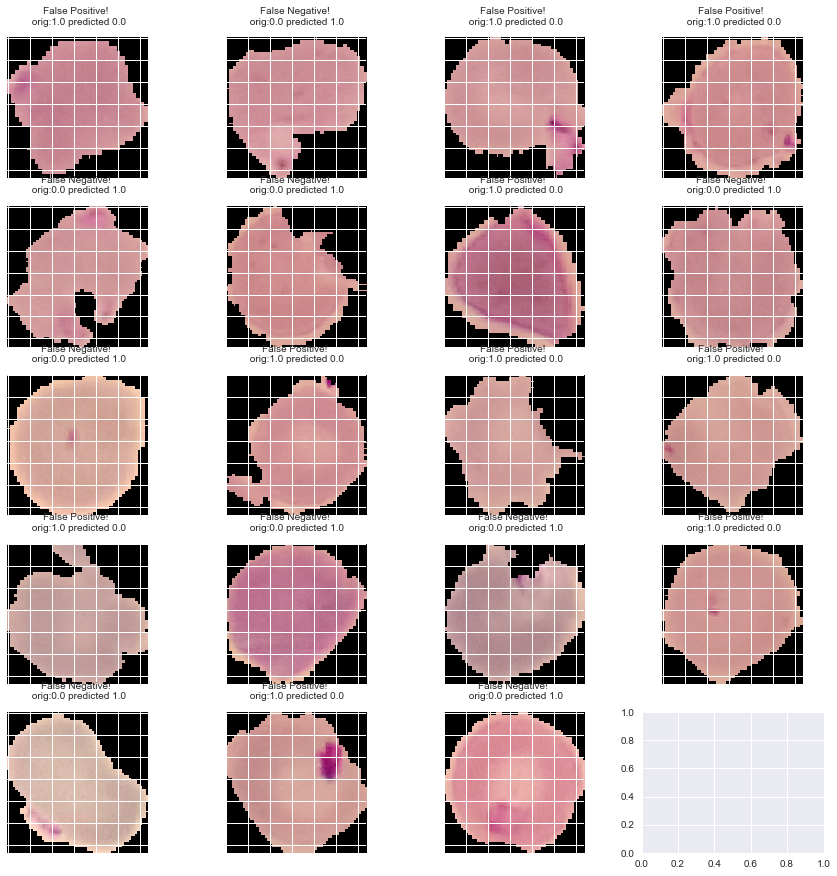

In [282]:
fig,ax=plt.subplots(5,4,figsize=(15,15))
index=0
for col_num in range(5):
    for row_num in range(4):
        cplt=ax[col_num][row_num]
        cplt.matshow(new_list[index][0])
        cplt.set_title(f'{new_list[index][1]}',fontsize=10) 
        cplt.set_xticklabels('')
        cplt.set_yticklabels('')
        index+=1
        if index>=len(new_list):
            break    

In [1]:
# layer_outputs = [layer.output for layer in final_model.layers[:9:2]] 
# # Extracts the outputs of the top 12 layers
# activation_model = tf.keras.Model(inputs=final_model.input, outputs=layer_outputs)
# count=0
# for i,v in new_list:
#     preds=activation_model.predict(i.reshape((1,128,128,3)))
#     fig,ax=plt.subplots(1,5,figsize=(15,20))
#     ax[0].matshow(i)
#     ax[0].set_xticklabels('')
#     ax[0].set_yticklabels('')
#     ax[0].set_title(v)
#     ax[-1].matshow(deepdreamimages[count]-100)
#     ax[-1].set_xticklabels('')
#     ax[-1].set_yticklabels('')
#     ax[-1].set_title(v)
#     for layer in range(3):
#         ax[layer+1].matshow(preds[layer][0,:,:,0],cmap='OrRd')
#         ax[layer+1].set_title(f'{model.predict(i.reshape((1,128,128,3)))},{model.predict_classes(i.reshape((1,128,128,3)))}')
#         ax[layer+1].set_xticklabels('')
#         ax[layer+1].set_yticklabels('')
#     count+=1

# This commented out portion was used to generate  our grouped pictures of the different layers for our presentation it broke afterwards so 